In [1]:
from openTSNE import TSNE, TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt

In [2]:
import anndata
import scanpy as sc

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
adata = anndata.read_h5ad(path.join("..", "data", "baron_2016h.h5ad"))
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 8569 × 17499 
    obs: 'batch_id', 'labels'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.18
Chosen offset: 1.16


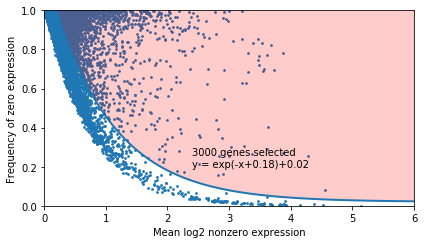

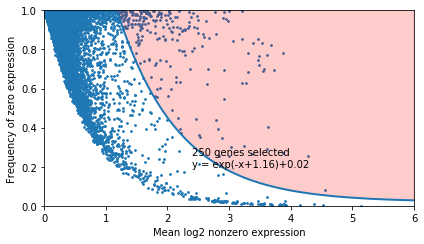

In [8]:
gene_mask_3000 = utils.select_genes(adata.X, n=3000, threshold=0)
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)

In [9]:
adata_norm = adata.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

In [10]:
adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

In [11]:
adata_250 = adata_norm[:, gene_mask_250].copy()
adata_3000 = adata_norm[:, gene_mask_3000].copy()
adata_full = adata_norm

In [12]:
%%time
for adata_ in [adata_250, adata_3000, adata_full]:
    print("Computing PCA for %d genes" % adata_.shape[1])
    U, S, V = np.linalg.svd(adata_.X, full_matrices=False)
    U[:, np.sum(V, axis=1) < 0] *= -1
    adata_.obsm["pca"] = np.dot(U, np.diag(S))
    adata_.obsm["pca"] = adata_.obsm["pca"][:, np.argsort(S)[::-1]][:, :50]

Computing PCA for 250 genes
Computing PCA for 3000 genes
Computing PCA for 17499 genes
CPU times: user 38min 2s, sys: 1min 12s, total: 39min 14s
Wall time: 1min 13s


## Run t-SNE

In [13]:
%%time
for adata_ in [adata_250, adata_3000, adata_full]:
    print("Computing t-SNE for %d genes" % adata_.shape[1])
    affinities = affinity.Multiscale(
        adata_.obsm["pca"],
        perplexities=[50, 500],
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    init = initialization.pca(adata_.obsm["pca"], random_state=42)
    embedding = TSNEEmbedding(
        init,
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
    )
    embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
    embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)
    
    adata_.obsm["tsne"] = embedding

Computing t-SNE for 250 genes
Computing t-SNE for 3000 genes
Computing t-SNE for 17499 genes
CPU times: user 30min 31s, sys: 25.7 s, total: 30min 57s
Wall time: 4min 17s


In [14]:
adata_250.write_h5ad("embedding_tsne_250_genes.h5ad")
adata_3000.write_h5ad("embedding_tsne_3000_genes.h5ad")
adata_full.write_h5ad("embedding_tsne_all_genes.h5ad")

... storing 'labels' as categorical
... storing 'labels' as categorical
... storing 'labels' as categorical


In [15]:
adata_250 = anndata.read_h5ad("embedding_tsne_250_genes.h5ad")
adata_3000 = anndata.read_h5ad("embedding_tsne_3000_genes.h5ad")
adata_full = anndata.read_h5ad("embedding_tsne_all_genes.h5ad")

In [16]:
legend_kwargs = dict(loc="center", bbox_to_anchor=(0.5, -0.05), ncol=len(np.unique(adata.obs["labels"])))

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


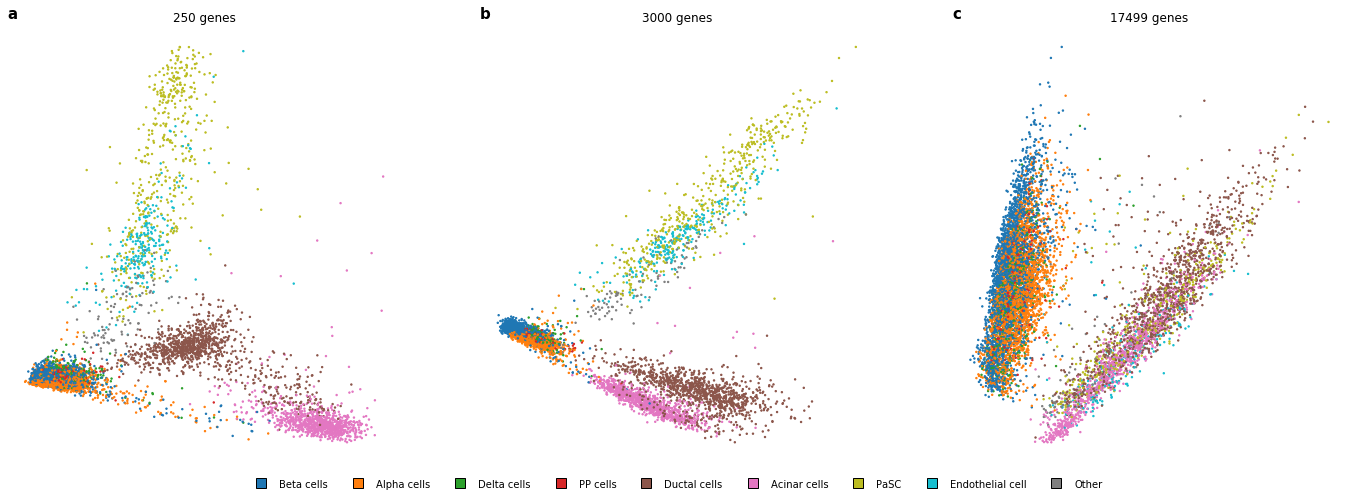

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["pca"], adata.obs["labels"],  s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
          legend_kwargs=legend_kwargs)
utils.plot(adata_full.obsm["pca"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="17499 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.tight_layout()

plt.savefig("embedding_pca_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


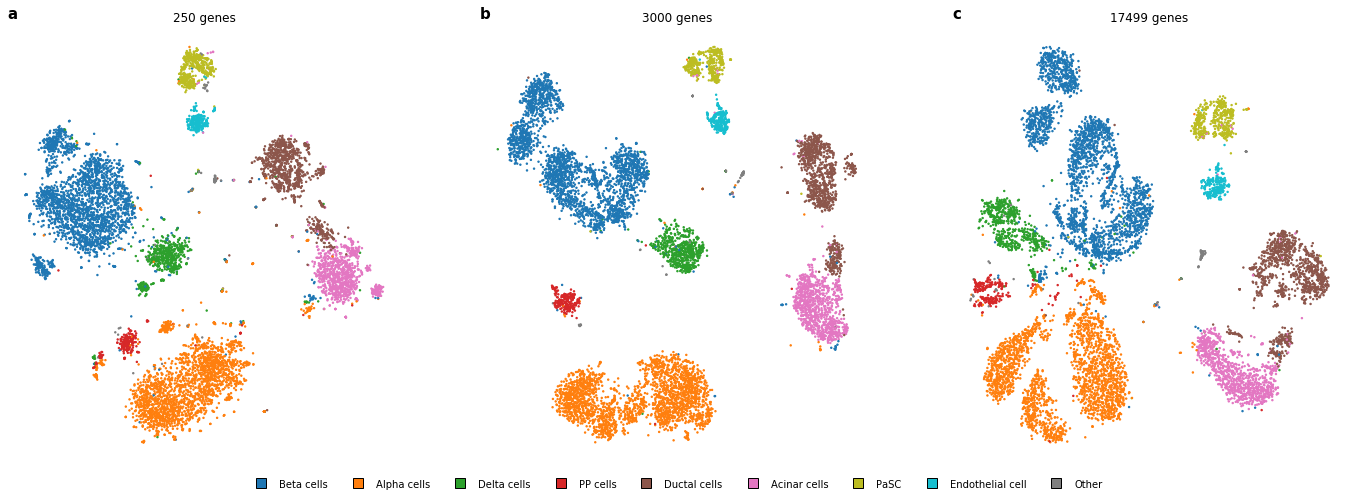

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

utils.plot(adata_250.obsm["tsne"],  adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[0], alpha=1, title="250 genes", label_order=list(colors.keys()))
utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=True, ax=ax[1], alpha=1, title="3000 genes", label_order=list(colors.keys()),
           legend_kwargs=legend_kwargs)
utils.plot(adata_full.obsm["tsne"], adata.obs["labels"], s=2, colors=colors, draw_legend=False, ax=ax[2], alpha=1, title="17499 genes", label_order=list(colors.keys()))

plt.text(0, 1.02, "a", transform=ax[0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[2].transAxes, fontsize=15, fontweight="bold")

plt.tight_layout()

plt.savefig("embedding_tsne_genes.pdf", dpi=600, bbox_inches="tight", transparent=True)

## Transform

In [19]:
new = anndata.read_h5ad(path.join("..", "data", "xin_2016.h5ad"))

In [21]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['A1BG', 'A1CF', 'A2M', 'A4GALT', 'AAAS', 'AACS', 'AACSP1', 'AADAC',
       'AADACL2', 'AADAT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='index', length=17078)

In [22]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [23]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Chosen offset: 1.16
Chosen offset: 0.45


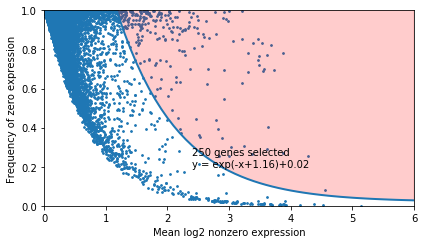

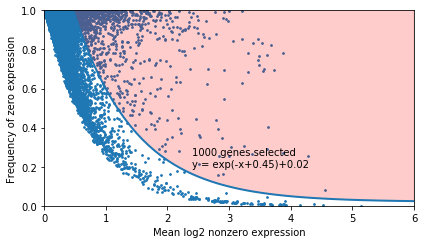

In [24]:
gene_mask_250 = utils.select_genes(adata.X, n=250, threshold=0)
gene_mask_1000 = utils.select_genes(adata.X, n=1000, threshold=0)

In [25]:
adata_250 = adata[:, gene_mask_250].copy()
adata_1000 = adata[:, gene_mask_1000].copy()
adata_full = adata

new_250 = new[:, gene_mask_250].copy()
new_1000 = new[:, gene_mask_1000].copy()
new_full = new

In [31]:
%%time
affinity_obs = {}
for adata_, new_ in [(adata_250, new_250), (adata_1000, new_1000), (adata_full, new_full)]:
    print("Running transform for %d genes" % adata_.shape[1])
    affinities = affinity.PerplexityBasedNN(
        adata_.X.toarray() if sp.issparse(adata_.X) else adata_.X,
        perplexity=30,
        metric="cosine",
        n_jobs=8,
        random_state=3,
    )
    affinity_obs[adata_.shape[1]] = affinities
    embedding = TSNEEmbedding(
        adata_3000.obsm["tsne"],
        affinities,
        negative_gradient_method="fft",
        n_jobs=8,
        callbacks=[ErrorLogger()],
    )
    new_embedding = embedding.prepare_partial(new_.X.toarray(), k=10)
    new_.obsm["tsne_init"] = new_embedding.copy()
    
    new_embedding.optimize(250, learning_rate=0.1, momentum=0.8, inplace=True)
    new_.obsm["tsne"] = new_embedding

Running transform for 250 genes
Iteration   50, KL divergence  16810.1976, 50 iterations in 3.8525 sec
Iteration  100, KL divergence  16806.5431, 50 iterations in 2.7434 sec
Iteration  150, KL divergence  16804.0901, 50 iterations in 1.7633 sec
Iteration  200, KL divergence  16805.2067, 50 iterations in 1.8097 sec
Iteration  250, KL divergence  16804.6104, 50 iterations in 2.8035 sec
Running transform for 1000 genes
Iteration   50, KL divergence  16694.7628, 50 iterations in 3.7593 sec
Iteration  100, KL divergence  16679.0153, 50 iterations in 3.4984 sec
Iteration  150, KL divergence  16678.7061, 50 iterations in 1.8706 sec
Iteration  200, KL divergence  16679.4670, 50 iterations in 1.4659 sec
Iteration  250, KL divergence  16677.5793, 50 iterations in 2.4231 sec
Running transform for 17078 genes
Iteration   50, KL divergence  16387.0453, 50 iterations in 4.0911 sec
Iteration  100, KL divergence  16380.9500, 50 iterations in 3.1822 sec
Iteration  150, KL divergence  16381.8247, 50 ite

In [32]:
new_250.write_h5ad("transform_tsne_250_genes.h5ad")
new_1000.write_h5ad("transform_tsne_1000_genes.h5ad")
new_full.write_h5ad("transform_tsne_all_genes.h5ad")

In [33]:
new_250 = anndata.read_h5ad("transform_tsne_250_genes.h5ad")
new_1000 = anndata.read_h5ad("transform_tsne_1000_genes.h5ad")
new_full = anndata.read_h5ad("transform_tsne_all_genes.h5ad")

In [34]:
new_full.shape

(1492, 17078)

Text(0, 1.02, 'd')

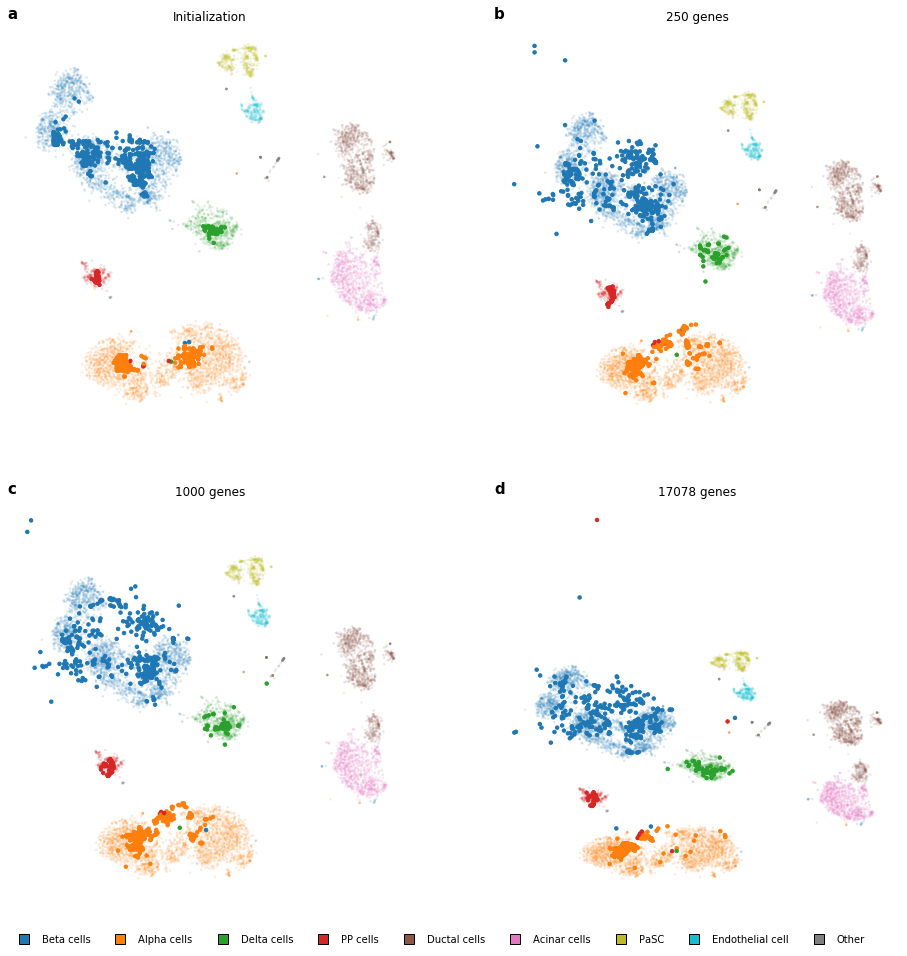

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=0.1, title="Initialization", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne_init"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=0.1, title="1000 genes", label_order=list(colors.keys()))
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=True, ax=ax[1, 1], alpha=0.1, title="17078 genes", label_order=list(colors.keys()),
          legend_kwargs=dict(bbox_transform=fig.transFigure, loc="lower center", bbox_to_anchor=(0.5, 0.075), ncol=len(np.unique(adata.obs["labels"]))))
utils.plot(new_full.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 1], alpha=1, label_order=list(colors.keys()))

#fig.tight_layout()

fig.text(0, 1.02, "a", transform=ax[0, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "b", transform=ax[0, 1].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "c", transform=ax[1, 0].transAxes, fontsize=15, fontweight="bold")
fig.text(0, 1.02, "d", transform=ax[1, 1].transAxes, fontsize=15, fontweight="bold")

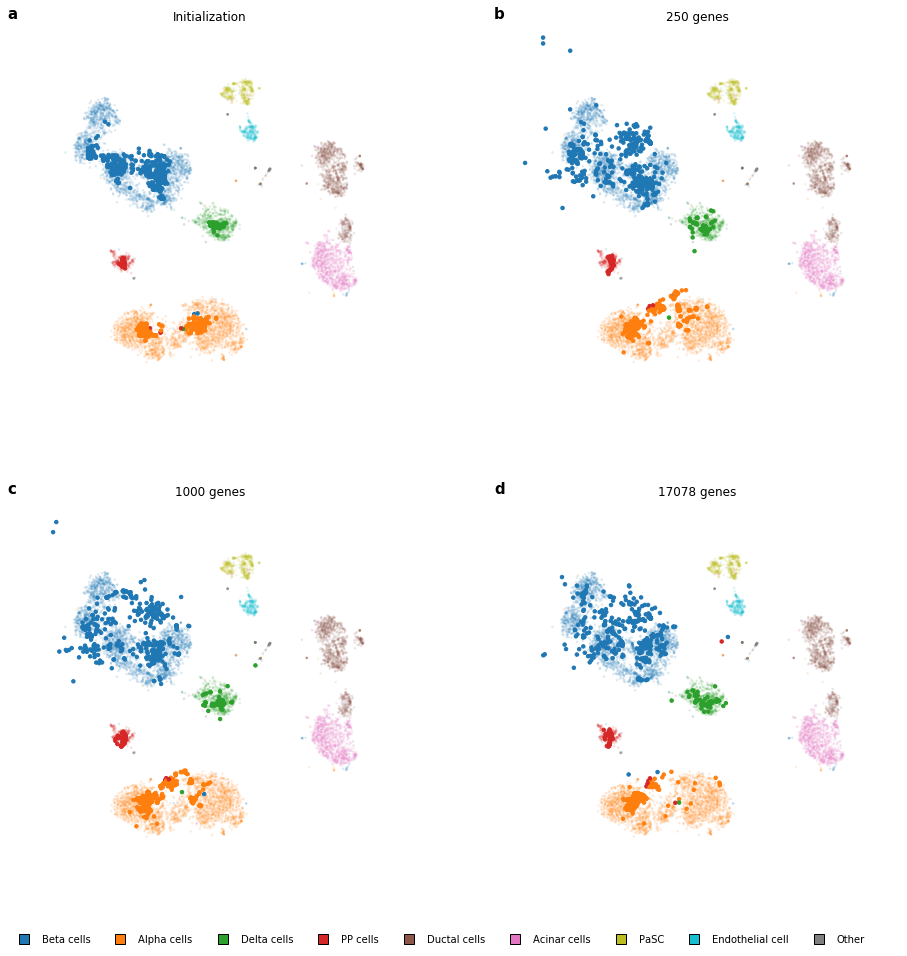

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=0.1, title="Initialization", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne_init"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=0.1, title="250 genes", label_order=list(colors.keys()))
utils.plot(new_250.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[0, 1], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=0.1, title="1000 genes", label_order=list(colors.keys()))
utils.plot(new_1000.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 0], alpha=1, label_order=list(colors.keys()))

utils.plot(adata_3000.obsm["tsne"], adata.obs["labels"], s=3, colors=colors, draw_legend=True, ax=ax[1, 1], alpha=0.1, title="17078 genes", label_order=list(colors.keys()),
          legend_kwargs=dict(bbox_transform=fig.transFigure, loc="lower center", bbox_to_anchor=(0.5, 0.075), ncol=len(np.unique(adata.obs["labels"]))))
utils.plot(new_full.obsm["tsne"], new.obs["labels"], s=12, colors=colors, draw_legend=False, ax=ax[1, 1], alpha=1, label_order=list(colors.keys()))

#plt.tight_layout()

coord_range = -50, 50
for ax_ in ax.ravel():
    ax_.set_xlim(*coord_range), ax_.set_ylim(*coord_range)

plt.text(0, 1.02, "a", transform=ax[0, 0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "b", transform=ax[0, 1].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "c", transform=ax[1, 0].transAxes, fontsize=15, fontweight="bold")
plt.text(0, 1.02, "d", transform=ax[1, 1].transAxes, fontsize=15, fontweight="bold")